<a href="https://colab.research.google.com/github/SudiWafula/DATA-ANALYTICS-CAPSTONE-PROJECT/blob/main/cnn_architecture_development_capstonep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the relevant libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import random
import cv2
from skimage.transform import resize
import pickle

In [4]:

file_path = '/content/drive/MyDrive/crop_resized_images.pkl'

with open(file_path, 'rb') as file:
    X_array = pickle.load(file)


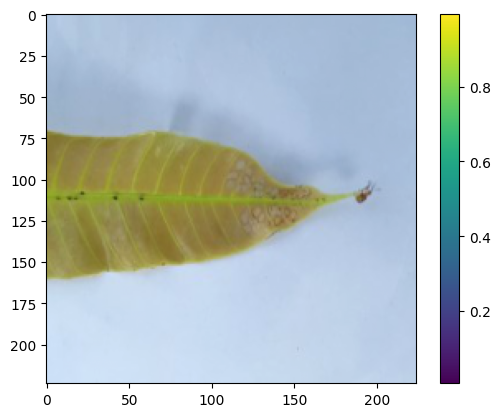

In [5]:
plt.figure()
plt.imshow(X_array[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
import pickle

file_path = '/content/drive/My Drive/y_array.pkl'

with open(file_path, 'rb') as f:
    y_array = pickle.load(f)


In [7]:
train_images, test_images, train_labels, test_labels = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


***Stage 2: CONVOLUTIONAL NEURAL NETWORKS (CNN)***

In [9]:
# Basic CNN
image_height = 224
image_width = 224
num_channels = 3
num_classes = 8
num_epochs = 30
batch_size = 15

class PrintAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') * 100
        print(f'Accuracy: {accuracy:.2f}%')

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print_accuracy_callback = PrintAccuracyCallback()

model.summary()

basic_cnn_hist = model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,
                           validation_data=(test_images, test_labels), callbacks=[print_accuracy_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 8)                 3154184   
                                                                 
Total params: 3,155,080
Trainable params: 3,155,080
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
214/214 [==============================] - 22s 101ms/step - loss: 3.5026 - accuracy: 0.5684 - val_los

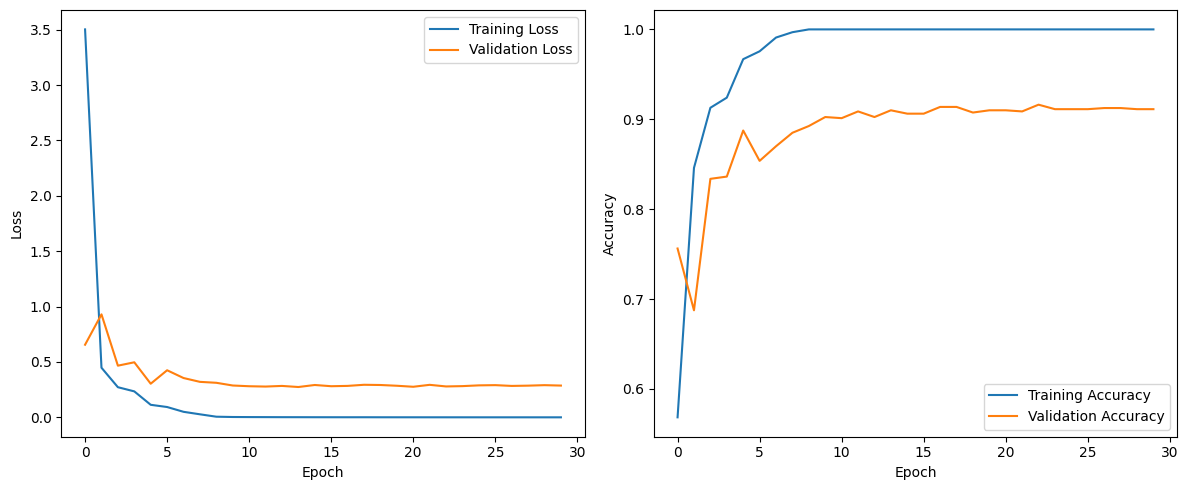

25/25 [==============================] - 1s 44ms/step


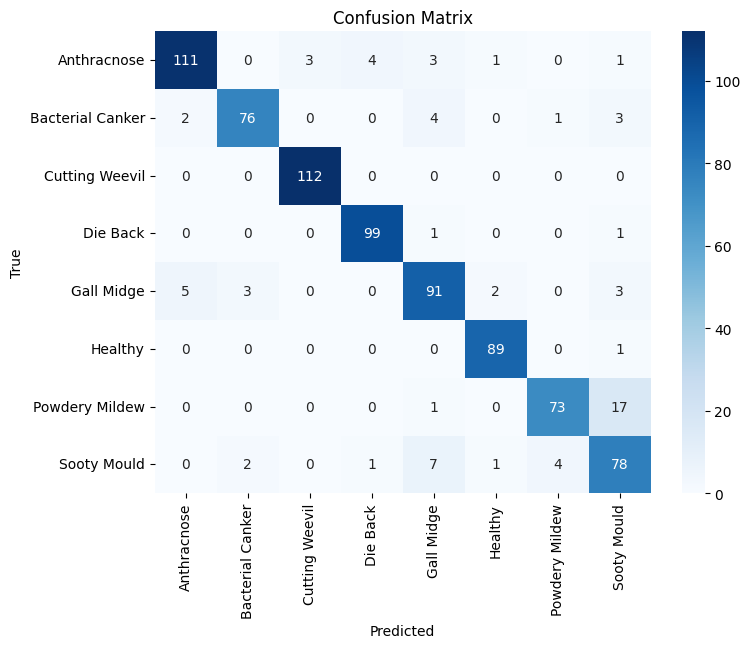

In [10]:

# training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(basic_cnn_hist.history['loss'], label='Training Loss')
plt.plot(basic_cnn_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(basic_cnn_hist.history['accuracy'], label='Training Accuracy')
plt.plot(basic_cnn_hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [15]:
test_labels_one_hot = to_categorical(test_labels, num_classes)

# Make predictions using your trained model
predicted_probabilities = model.predict(test_images)

# Calculate ROC curves and AUC for each class
roc_curves = []
auc_scores = []

for class_index in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, class_index], predicted_probabilities[:, class_index])
    roc_curves.append((fpr, tpr))
    auc_scores.append(auc(fpr, tpr))


25/25 [==============================] - 1s 44ms/step


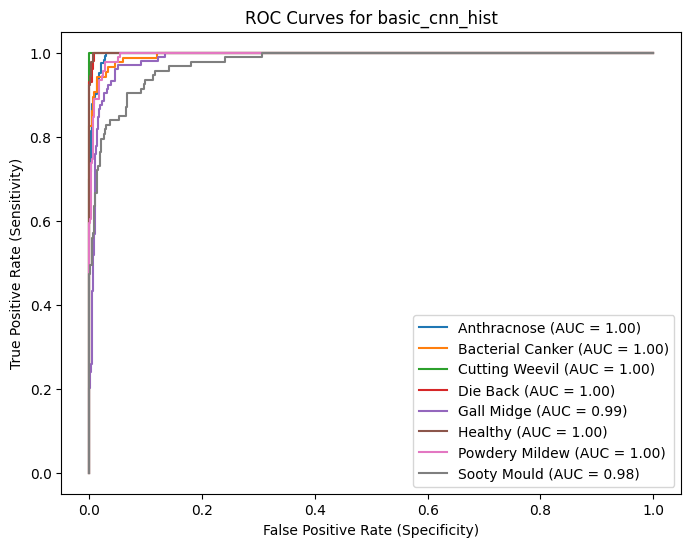

In [23]:
class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]
# Create a figure and axis for plotting
plt.figure(figsize=(8, 6))

for class_index in range(num_classes):
    fpr, tpr = roc_curves[class_index]
    auc_score = auc(fpr, tpr)

    # Customize the label with class names and AUC score
    label = f'{class_names[class_index]} (AUC = {auc_score:.2f})'

    plt.plot(fpr, tpr, label=label)

# Customize axis labels, title, and legend
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for basic_cnn_hist')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [20]:
y_true = test_labels  # True labels
y_pred = predicted_probabilities.argmax(axis=1)  # Predicted labels

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')


Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-Score: 0.91


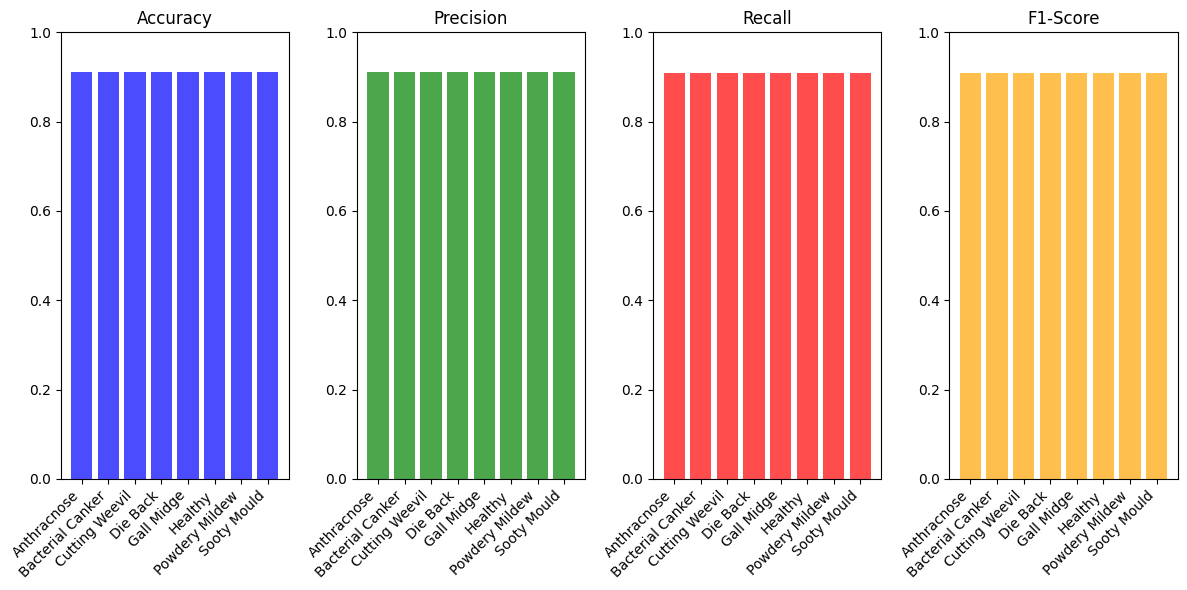

In [22]:
# Define class names
class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

# metric values
accuracy_values = [accuracy]
precision_values = [precision]
recall_values = [recall]
f1_values = [f1]

# bar plots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.bar(class_names, accuracy_values, color='b', alpha=0.7)
plt.ylim([0, 1])
plt.title('Accuracy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 2)
plt.bar(class_names, precision_values, color='g', alpha=0.7)
plt.ylim([0, 1])
plt.title('Precision')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 3)
plt.bar(class_names, recall_values, color='r', alpha=0.7)
plt.ylim([0, 1])
plt.title('Recall')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 4)
plt.bar(class_names, f1_values, color='orange', alpha=0.7)
plt.ylim([0, 1])
plt.title('F1-Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [24]:
# model 2

In [25]:

class PrintAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') * 100
        print(f'Accuracy: {accuracy:.2f}%')

def second_basic_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu')) #added layer
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    return model

def train_basic_cnn_model(model, train_images, train_labels, test_images, test_labels, num_epochs, batch_size):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print_accuracy_callback = PrintAccuracyCallback()
    model.summary()
    basic_cnn_hist = model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,
                               validation_data=(test_images, test_labels), callbacks=[print_accuracy_callback])
    return basic_cnn_hist

image_height = 224
image_width = 224
num_channels = 3
num_classes = 8
num_epochs = 30
batch_size = 15

model2 = second_basic_cnn_model(input_shape=(image_height, image_width, num_channels), num_classes=num_classes)

basic_cnn_hist2 = train_basic_cnn_model(model2, train_images, train_labels, test_images, test_labels, num_epochs, batch_size)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_1 (Dense)             (None, 8)                

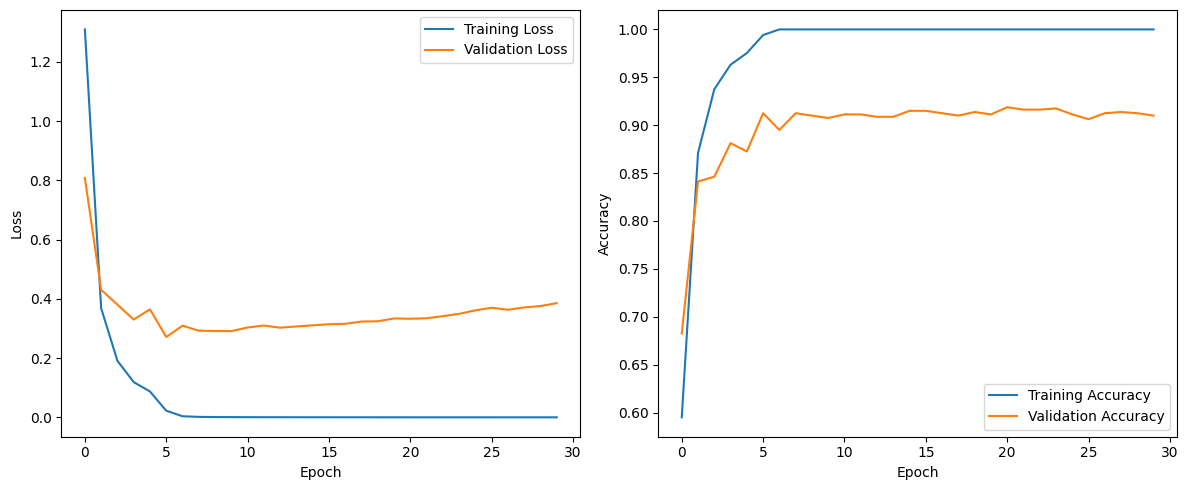

25/25 [==============================] - 2s 71ms/step


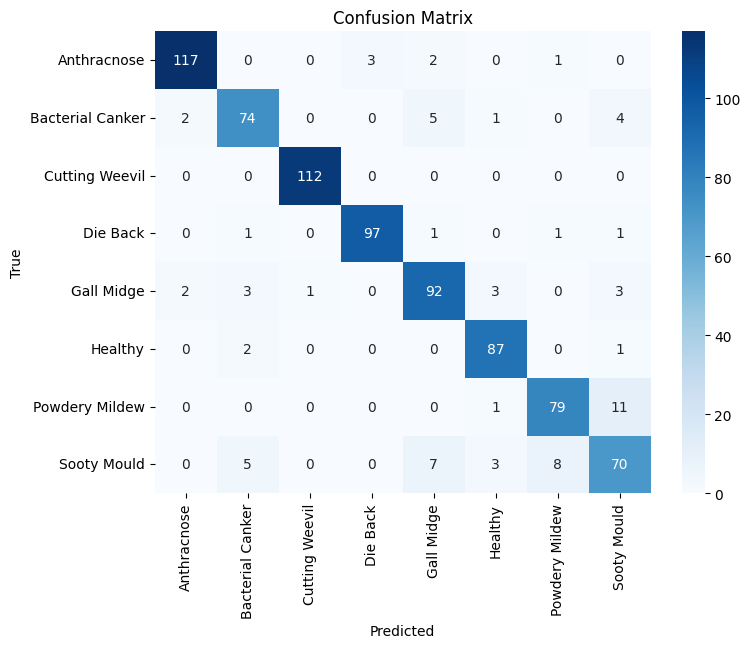

In [43]:
# training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(basic_cnn_hist2.history['loss'], label='Training Loss')
plt.plot(basic_cnn_hist2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(basic_cnn_hist2.history['accuracy'], label='Training Accuracy')
plt.plot(basic_cnn_hist2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

predictions = model2.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

confus_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confus_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [27]:
test_labels_one_hot = to_categorical(test_labels, num_classes)

# Make predictions using your trained model
predicted_probabilities2 = model2.predict(test_images)

# Calculate ROC curves and AUC for each class
roc_curves2 = []
auc_scores2 = []

for class_index in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, class_index], predicted_probabilities2[:, class_index])
    roc_curves2.append((fpr, tpr))
    auc_scores2.append(auc(fpr, tpr))

25/25 [==============================] - 2s 73ms/step


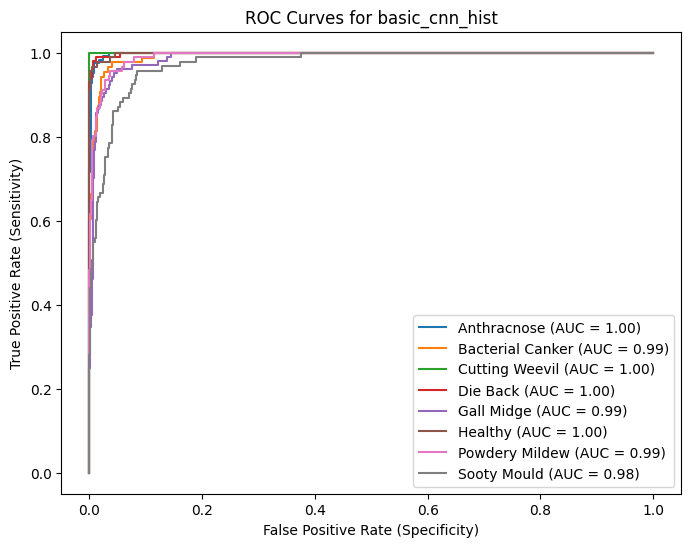

In [28]:
class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]
# Create a figure and axis for plotting
plt.figure(figsize=(8, 6))

for class_index in range(num_classes):
    fpr, tpr = roc_curves2[class_index]
    auc_score2 = auc(fpr, tpr)

    # Customize the label with class names and AUC score
    label = f'{class_names[class_index]} (AUC = {auc_score2:.2f})'

    plt.plot(fpr, tpr, label=label)

# Customize axis labels, title, and legend
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for basic_cnn_hist')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [30]:
y_true2 = test_labels  # True labels
y_pred2 = predicted_probabilities2.argmax(axis=1)  # Predicted labels

accuracy2 = accuracy_score(y_true2, y_pred2)
print(f'Accuracy: {accuracy2:.2f}')

precision2 = precision_score(y_true2, y_pred2, average='macro')
recall2 = recall_score(y_true2, y_pred2, average='macro')
f1_2 = f1_score(y_true2, y_pred2, average='macro')

print(f'Precision: {precision2:.2f}')
print(f'Recall: {recall2:.2f}')
print(f'F1-Score: {f1_2:.2f}')

Accuracy: 0.91
Precision: 0.90
Recall: 0.91
F1-Score: 0.91


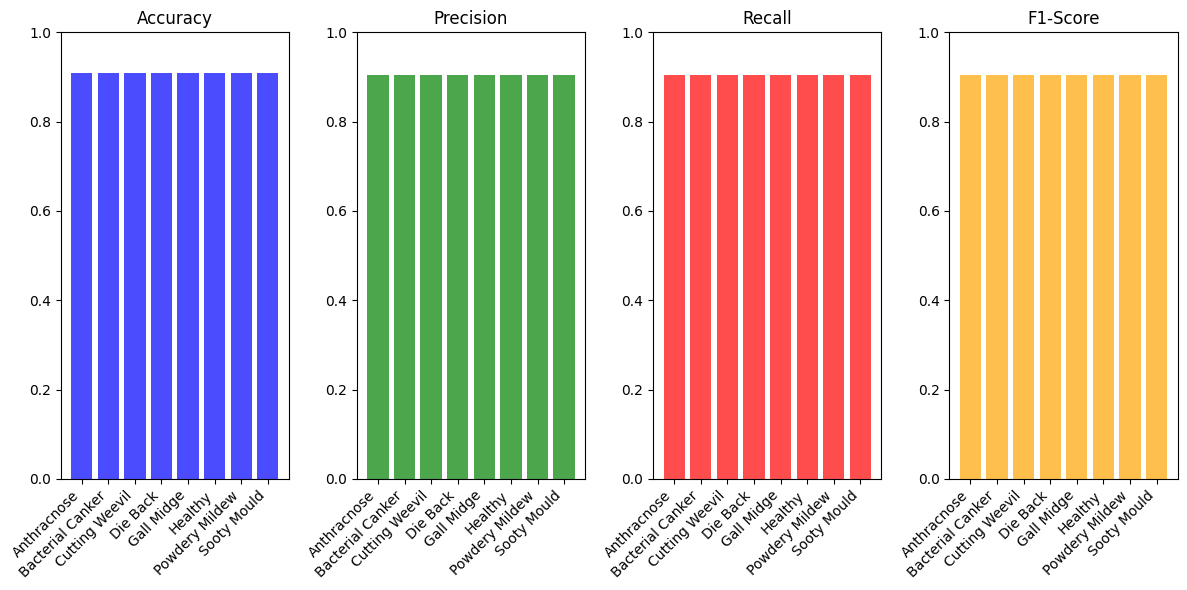

In [31]:
# metric values
accuracy_values = [accuracy2]
precision_values = [precision2]
recall_values = [recall2]
f1_values = [f1_2]

# bar plots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.bar(class_names, accuracy_values, color='b', alpha=0.7)
plt.ylim([0, 1])
plt.title('Accuracy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 2)
plt.bar(class_names, precision_values, color='g', alpha=0.7)
plt.ylim([0, 1])
plt.title('Precision')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 3)
plt.bar(class_names, recall_values, color='r', alpha=0.7)
plt.ylim([0, 1])
plt.title('Recall')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 4)
plt.bar(class_names, f1_values, color='orange', alpha=0.7)
plt.ylim([0, 1])
plt.title('F1-Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [32]:
# model 3

In [33]:
class PrintAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') * 100
        print(f'Accuracy: {accuracy:.2f}%')

def third_basic_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def train_basic_cnn_model(model, train_images, train_labels, test_images, test_labels, num_epochs, batch_size):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print_accuracy_callback = PrintAccuracyCallback()
    model.summary()
    basic_cnn_hist = model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,
                               validation_data=(test_images, test_labels), callbacks=[print_accuracy_callback])
    return basic_cnn_hist

# constants
image_height = 224
image_width = 224
num_channels = 3
num_classes = 8
num_epochs = 30
batch_size = 15

model3 = third_basic_cnn_model(input_shape=(image_height, image_width, num_channels), num_classes=num_classes)

basic_cnn_hist3 = train_basic_cnn_model(model3, train_images, train_labels, test_images, test_labels, num_epochs, batch_size)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

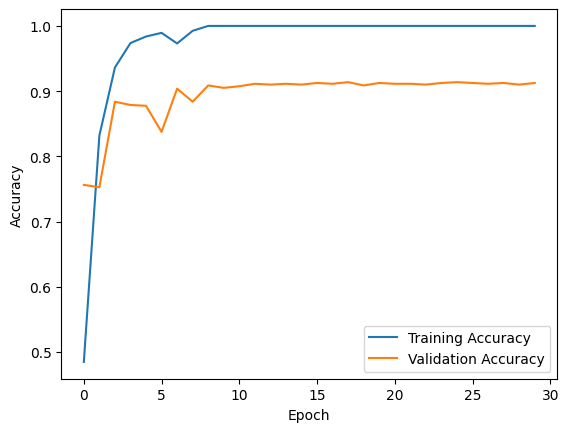

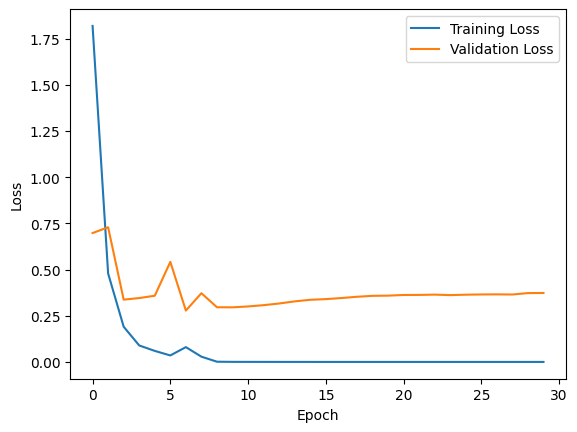

In [34]:
plt.plot(basic_cnn_hist3.history['accuracy'], label='Training Accuracy')
plt.plot(basic_cnn_hist3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# training and validation loss
plt.plot(basic_cnn_hist3.history['loss'], label='Training Loss')
plt.plot(basic_cnn_hist3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 [==============================] - 2s 76ms/step


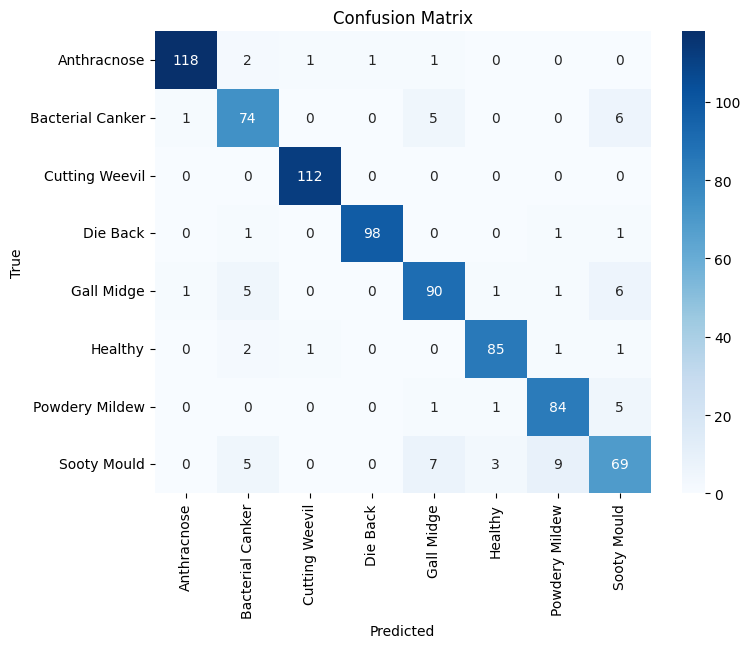

In [42]:

preds = model3.predict(test_images)
predicted_labels = np.argmax(preds, axis=1)

class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

confx_mat = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confx_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [36]:
test_labels_one_hot = to_categorical(test_labels, num_classes)

predicted_probabilities3 = model3.predict(test_images)

roc_curves3 = []
auc_scores3 = []

for class_index in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, class_index], predicted_probabilities3[:, class_index])
    roc_curves3.append((fpr, tpr))
    auc_scores3.append(auc(fpr, tpr))

25/25 [==============================] - 2s 72ms/step


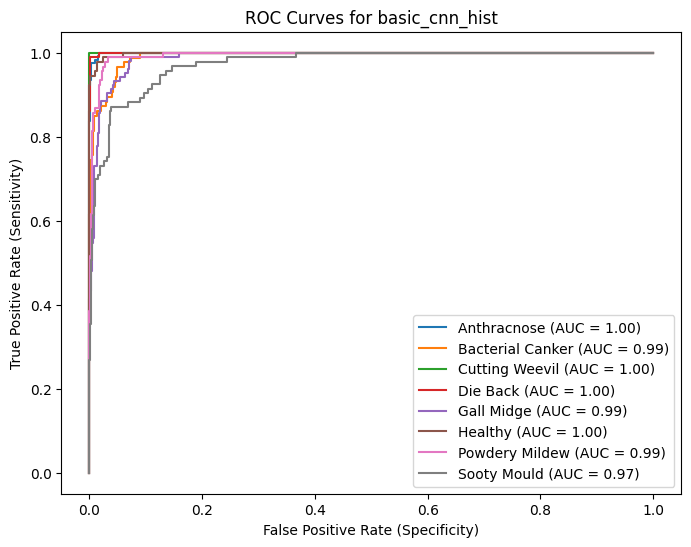

In [37]:
class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

plt.figure(figsize=(8, 6))

for class_index in range(num_classes):
    fpr, tpr = roc_curves3[class_index]
    auc_score3 = auc(fpr, tpr)

    label = f'{class_names[class_index]} (AUC = {auc_score3:.2f})'

    plt.plot(fpr, tpr, label=label)

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for basic_cnn_hist')
plt.legend(loc='lower right')

plt.show()

In [38]:
y_true3 = test_labels  # True labels
y_pred3 = predicted_probabilities3.argmax(axis=1)  # Predicted labels

accuracy3 = accuracy_score(y_true3, y_pred3)
print(f'Accuracy: {accuracy3:.2f}')

precision3 = precision_score(y_true3, y_pred3, average='macro')
recall3 = recall_score(y_true3, y_pred3, average='macro')
f1_3 = f1_score(y_true3, y_pred3, average='macro')

print(f'Precision: {precision3:.2f}')
print(f'Recall: {recall3:.2f}')
print(f'F1-Score: {f1_3:.2f}')

Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-Score: 0.91


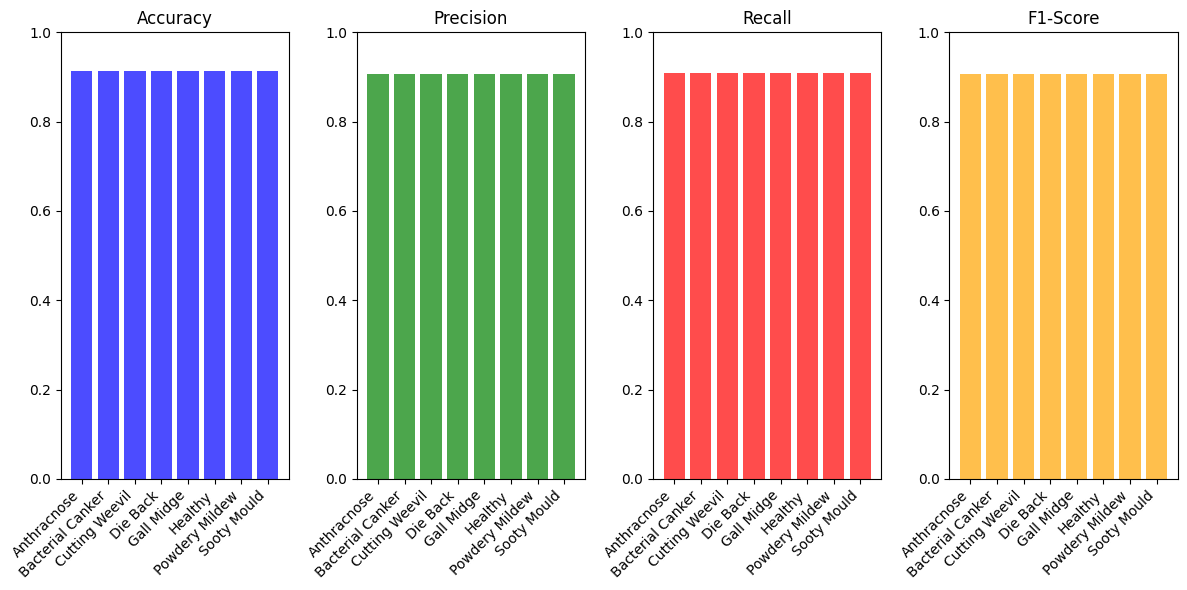

In [39]:
# metric values
accuracy_values = [accuracy3]
precision_values = [precision3]
recall_values = [recall3]
f1_values = [f1_3]

# bar plots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.bar(class_names, accuracy_values, color='b', alpha=0.7)
plt.ylim([0, 1])
plt.title('Accuracy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 2)
plt.bar(class_names, precision_values, color='g', alpha=0.7)
plt.ylim([0, 1])
plt.title('Precision')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 3)
plt.bar(class_names, recall_values, color='r', alpha=0.7)
plt.ylim([0, 1])
plt.title('Recall')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 4)
plt.bar(class_names, f1_values, color='orange', alpha=0.7)
plt.ylim([0, 1])
plt.title('F1-Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [40]:
# model4

In [41]:
class PrintAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') * 100
        print(f'Accuracy: {accuracy:.2f}%')

def fourth_basic_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def train_basic_cnn_model(model, train_images, train_labels, test_images, test_labels, num_epochs, batch_size):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print_accuracy_callback = PrintAccuracyCallback()
    model.summary()
    basic_cnn_hist = model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,
                               validation_data=(test_images, test_labels), callbacks=[print_accuracy_callback])
    return basic_cnn_hist

# constants
image_height = 224
image_width = 224
num_channels = 3
num_classes = 8
num_epochs = 30
batch_size = 15

model4 = fourth_basic_cnn_model(input_shape=(image_height, image_width, num_channels), num_classes=num_classes)

basic_cnn_hist4 = train_basic_cnn_model(model4, train_images, train_labels, test_images, test_labels, num_epochs, batch_size)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 flatten_3 (Flatten)         (None, 346112)           

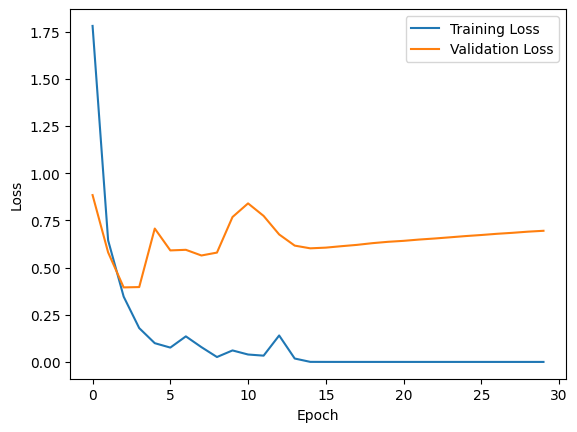

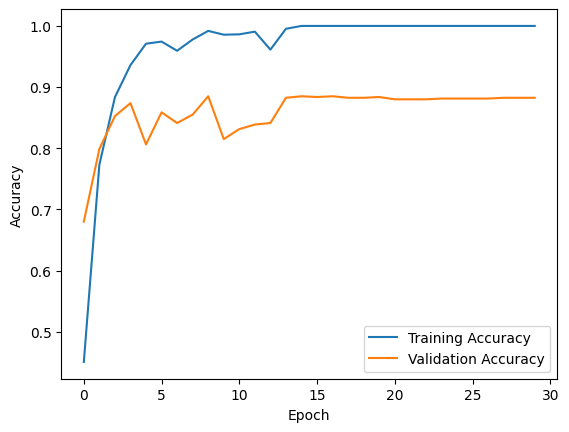

In [44]:
# training and validation loss
plt.plot(basic_cnn_hist4.history['loss'], label='Training Loss')
plt.plot(basic_cnn_hist4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# training and validation accuracy
plt.plot(basic_cnn_hist4.history['accuracy'], label='Training Accuracy')
plt.plot(basic_cnn_hist4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

25/25 [==============================] - 3s 103ms/step


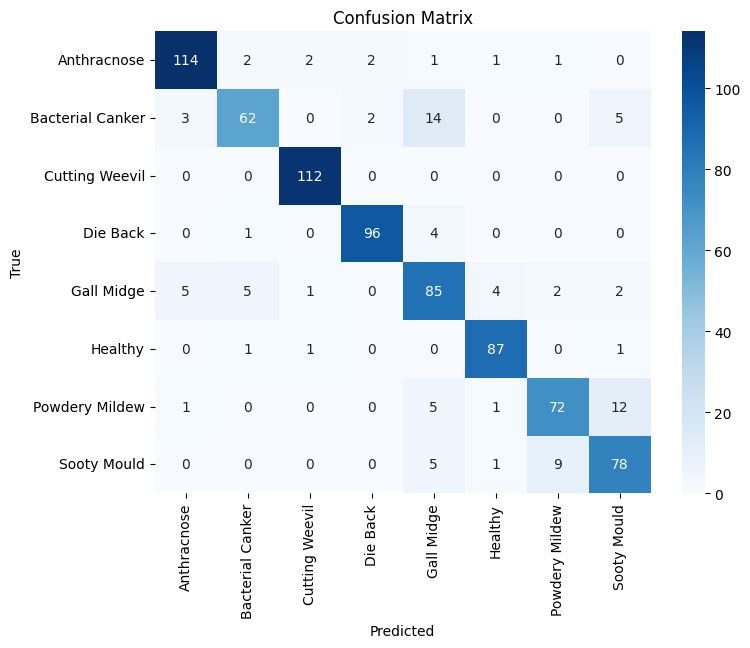

In [45]:
preds = model4.predict(test_images)
predicted_labels = np.argmax(preds, axis=1)

class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

confusion_matxx = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matxx, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [46]:
test_labels_one_hot = to_categorical(test_labels, num_classes)

predicted_probabilities4 = model4.predict(test_images)

roc_curves4 = []
auc_scores4 = []

for class_index in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, class_index], predicted_probabilities4[:, class_index])
    roc_curves4.append((fpr, tpr))
    auc_scores4.append(auc(fpr, tpr))

25/25 [==============================] - 3s 99ms/step


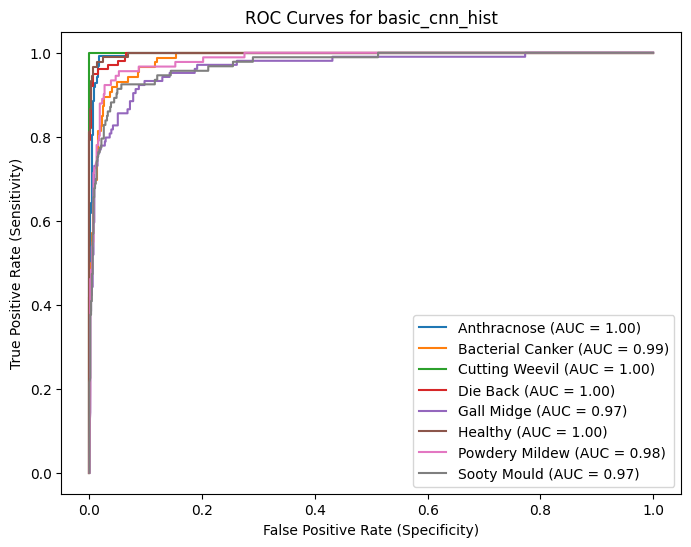

In [47]:
class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

plt.figure(figsize=(8, 6))

for class_index in range(num_classes):
    fpr, tpr = roc_curves4[class_index]
    auc_score4 = auc(fpr, tpr)

    label = f'{class_names[class_index]} (AUC = {auc_score4:.2f})'

    plt.plot(fpr, tpr, label=label)

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for basic_cnn_hist')
plt.legend(loc='lower right')

plt.show()

In [48]:
y_true4 = test_labels  # True labels
y_pred4 = predicted_probabilities4.argmax(axis=1)  # Predicted labels

accuracy4 = accuracy_score(y_true4, y_pred4)
print(f'Accuracy: {accuracy4:.2f}')

precision4 = precision_score(y_true4, y_pred4, average='macro')
recall4 = recall_score(y_true4, y_pred4, average='macro')
f1_4 = f1_score(y_true4, y_pred4, average='macro')

print(f'Precision: {precision4:.2f}')
print(f'Recall: {recall4:.2f}')
print(f'F1-Score: {f1_4:.2f}')

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1-Score: 0.88


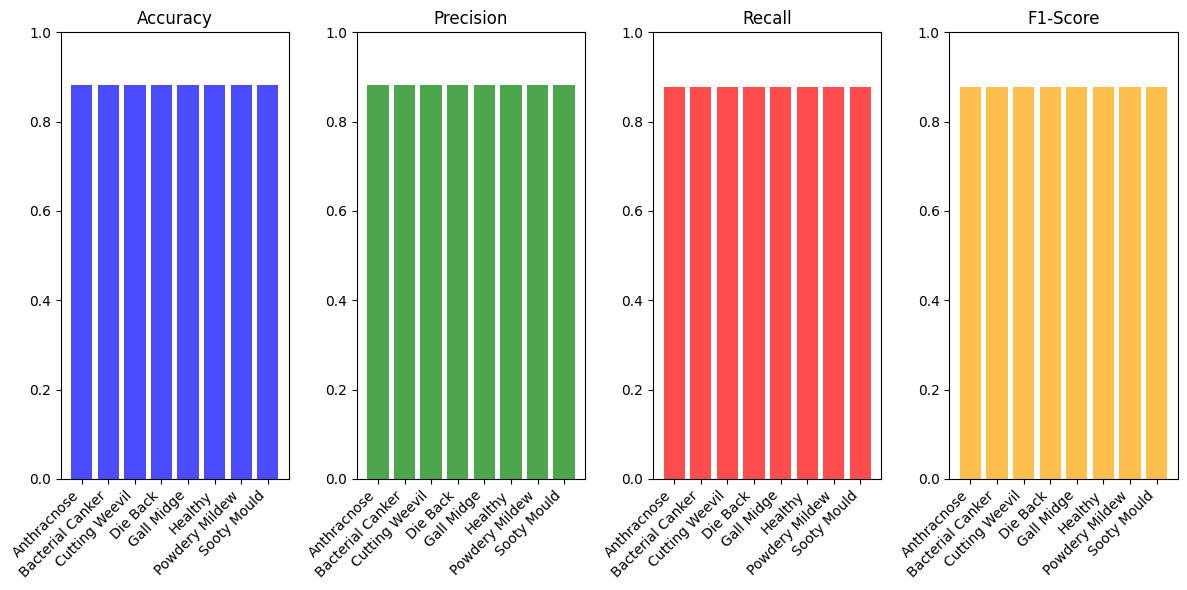

In [49]:
# metric values
accuracy_values = [accuracy4]
precision_values = [precision4]
recall_values = [recall4]
f1_values = [f1_4]

# bar plots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.bar(class_names, accuracy_values, color='b', alpha=0.7)
plt.ylim([0, 1])
plt.title('Accuracy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 2)
plt.bar(class_names, precision_values, color='g', alpha=0.7)
plt.ylim([0, 1])
plt.title('Precision')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 3)
plt.bar(class_names, recall_values, color='r', alpha=0.7)
plt.ylim([0, 1])
plt.title('Recall')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 4)
plt.bar(class_names, f1_values, color='orange', alpha=0.7)
plt.ylim([0, 1])
plt.title('F1-Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [50]:
# model5

In [51]:

class PrintAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') * 100
        print(f'Accuracy: {accuracy:.2f}%')

def fifth_basic_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def train_basic_cnn_model(model, train_images, train_labels, test_images, test_labels, num_epochs, batch_size):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print_accuracy_callback = PrintAccuracyCallback()
    model.summary()
    basic_cnn_hist = model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,
                               validation_data=(test_images, test_labels), callbacks=[print_accuracy_callback])
    return basic_cnn_hist

# constants
image_height = 224
image_width = 224
num_channels = 3
num_classes = 8
num_epochs = 30
batch_size = 15

model5 = fifth_basic_cnn_model(input_shape=(image_height, image_width, num_channels), num_classes=num_classes)

basic_cnn_hist5 = train_basic_cnn_model(model5, train_images, train_labels, test_images, test_labels, num_epochs, batch_size)




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 flatten_4 (Flatten)         (None, 346112)           

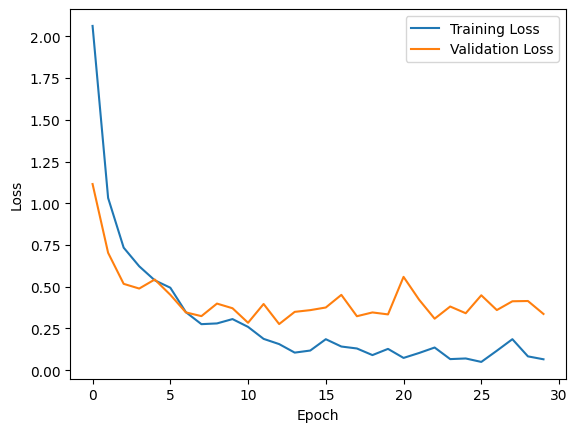

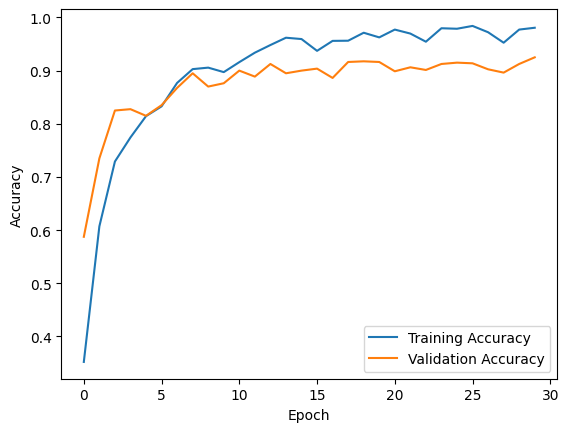

In [52]:
# training and validation loss
plt.plot(basic_cnn_hist5.history['loss'], label='Training Loss')
plt.plot(basic_cnn_hist5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# training and validation accuracy
plt.plot(basic_cnn_hist5.history['accuracy'], label='Training Accuracy')
plt.plot(basic_cnn_hist5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

25/25 [==============================] - 3s 103ms/step


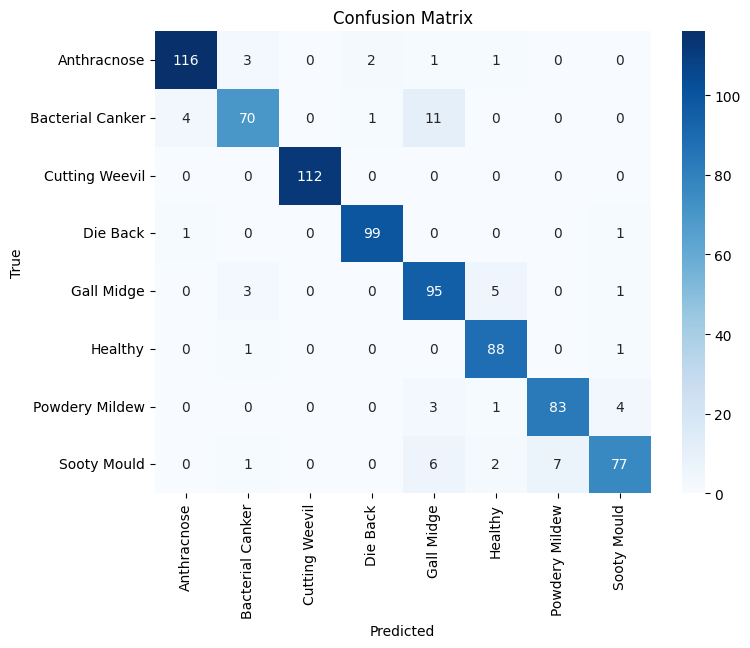

In [53]:
preds = model5.predict(test_images)
predicted_labels = np.argmax(preds, axis=1)

class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

confusion_matrxx = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrxx, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [54]:
test_labels_one_hot = to_categorical(test_labels, num_classes)

predicted_probabilities5 = model5.predict(test_images)

roc_curves5 = []
auc_scores5 = []

for class_index in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, class_index], predicted_probabilities5[:, class_index])
    roc_curves5.append((fpr, tpr))
    auc_scores5.append(auc(fpr, tpr))

25/25 [==============================] - 2s 94ms/step


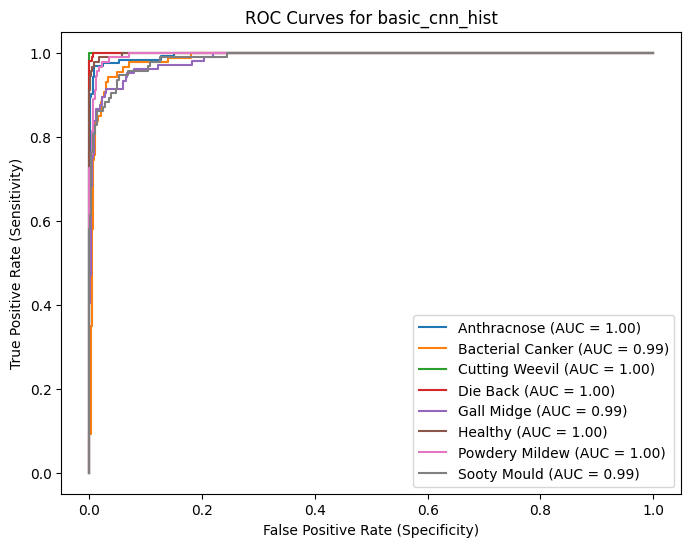

In [55]:
class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

plt.figure(figsize=(8, 6))

for class_index in range(num_classes):
    fpr, tpr = roc_curves5[class_index]
    auc_score5 = auc(fpr, tpr)

    label = f'{class_names[class_index]} (AUC = {auc_score5:.2f})'

    plt.plot(fpr, tpr, label=label)

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for basic_cnn_hist')
plt.legend(loc='lower right')

plt.show()

In [56]:
y_true5 = test_labels  # True labels
y_pred5 = predicted_probabilities5.argmax(axis=1)  # Predicted labels

accuracy5 = accuracy_score(y_true5, y_pred5)
print(f'Accuracy: {accuracy5:.2f}')

precision5 = precision_score(y_true5, y_pred5, average='macro')
recall5 = recall_score(y_true5, y_pred5, average='macro')
f1_5 = f1_score(y_true5, y_pred5, average='macro')

print(f'Precision: {precision5:.2f}')
print(f'Recall: {recall5:.2f}')
print(f'F1-Score: {f1_5:.2f}')

Accuracy: 0.93
Precision: 0.92
Recall: 0.92
F1-Score: 0.92


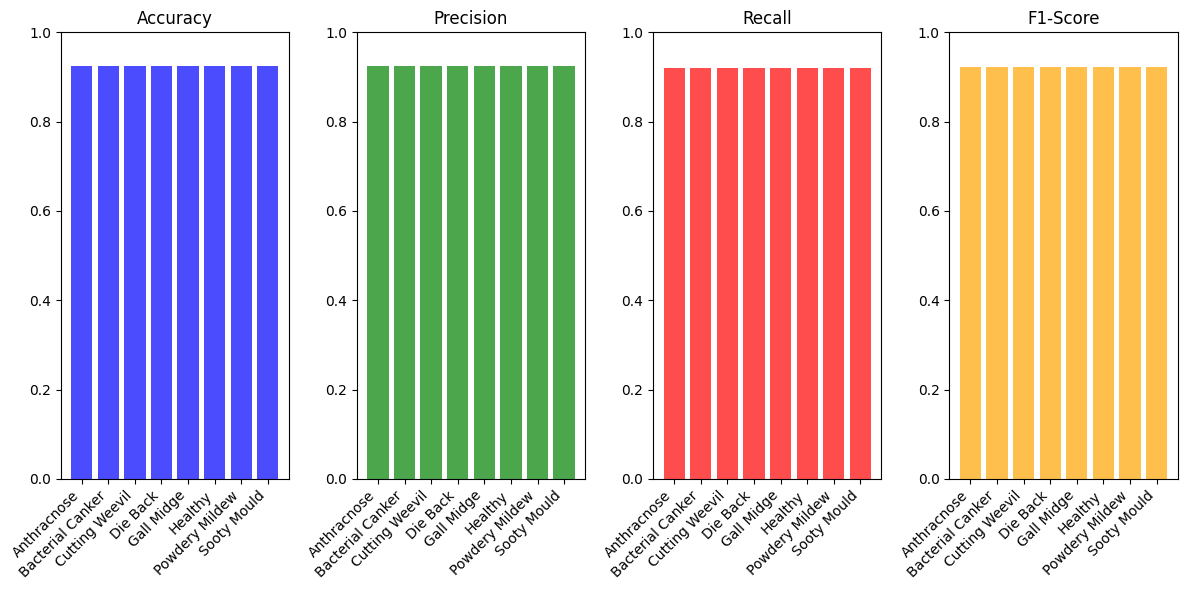

In [57]:
# metric values
accuracy_values = [accuracy5]
precision_values = [precision5]
recall_values = [recall5]
f1_values = [f1_5]

# bar plots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.bar(class_names, accuracy_values, color='b', alpha=0.7)
plt.ylim([0, 1])
plt.title('Accuracy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 2)
plt.bar(class_names, precision_values, color='g', alpha=0.7)
plt.ylim([0, 1])
plt.title('Precision')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 3)
plt.bar(class_names, recall_values, color='r', alpha=0.7)
plt.ylim([0, 1])
plt.title('Recall')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 4)
plt.bar(class_names, f1_values, color='orange', alpha=0.7)
plt.ylim([0, 1])
plt.title('F1-Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [58]:
# model6
# added maxpooling on the last layer

In [59]:

class PrintAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') * 100
        print(f'Accuracy: {accuracy:.2f}%')

def sixth_basic_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def train_basic_cnn_model(model, train_images, train_labels, test_images, test_labels, num_epochs, batch_size):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print_accuracy_callback = PrintAccuracyCallback()
    model.summary()
    basic_cnn_hist = model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,
                               validation_data=(test_images, test_labels), callbacks=[print_accuracy_callback])
    return basic_cnn_hist

# constants
image_height = 224
image_width = 224
num_channels = 3
num_classes = 8
num_epochs = 30
batch_size = 15

model6 = sixth_basic_cnn_model(input_shape=(image_height, image_width, num_channels), num_classes=num_classes)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

basic_cnn_hist6 = train_basic_cnn_model(model6, train_images, train_labels, test_images, test_labels, num_epochs, batch_size)



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 128)     

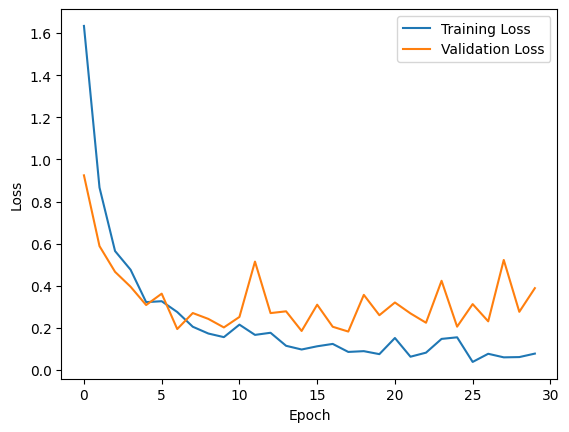

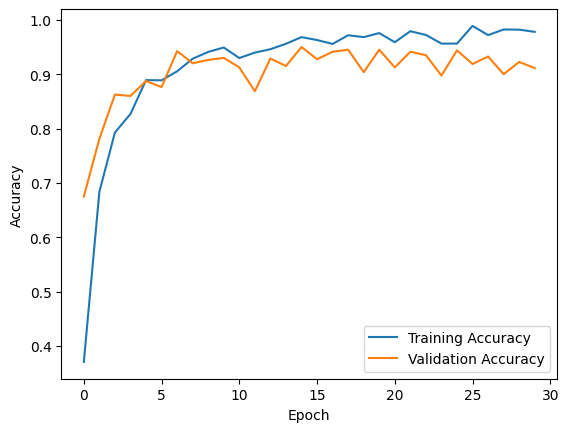

In [60]:
# training and validation loss
plt.plot(basic_cnn_hist6.history['loss'], label='Training Loss')
plt.plot(basic_cnn_hist6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# training and validation accuracy
plt.plot(basic_cnn_hist6.history['accuracy'], label='Training Accuracy')
plt.plot(basic_cnn_hist6.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

25/25 [==============================] - 2s 84ms/step


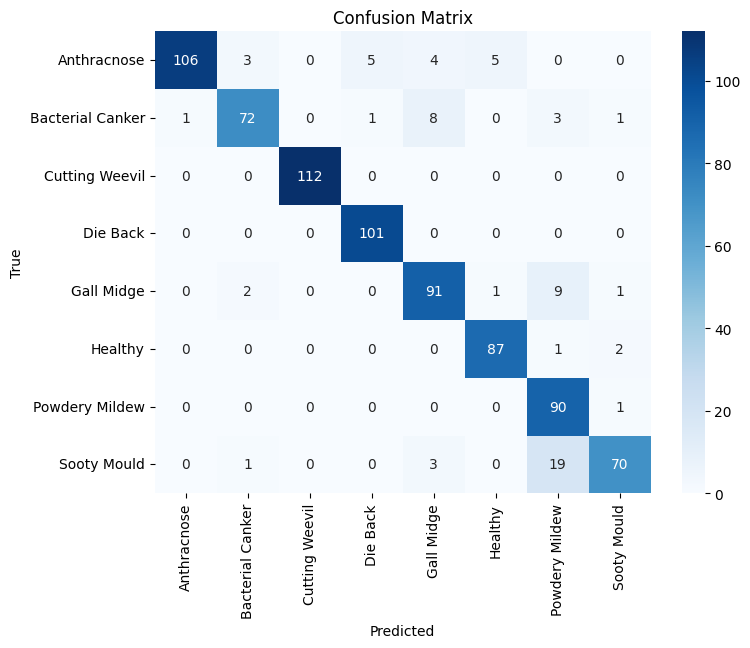

In [61]:
preds = model6.predict(test_images)
predicted_labels = np.argmax(preds, axis=1)

class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

conf_mat6 = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat6, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [62]:
test_labels_one_hot = to_categorical(test_labels, num_classes)

predicted_probabilities6 = model6.predict(test_images)

roc_curves6 = []
auc_scores6 = []

for class_index in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, class_index], predicted_probabilities6[:, class_index])
    roc_curves6.append((fpr, tpr))
    auc_scores6.append(auc(fpr, tpr))

25/25 [==============================] - 2s 80ms/step


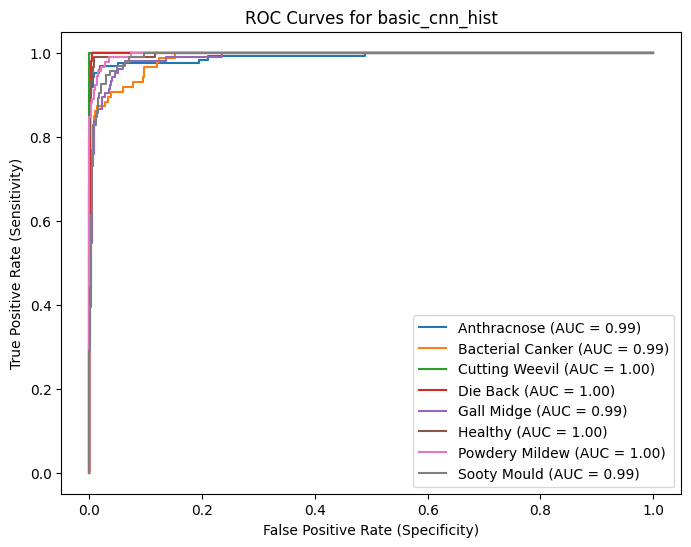

In [63]:
class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

plt.figure(figsize=(8, 6))

for class_index in range(num_classes):
    fpr, tpr = roc_curves6[class_index]
    auc_score6 = auc(fpr, tpr)

    label = f'{class_names[class_index]} (AUC = {auc_score6:.2f})'

    plt.plot(fpr, tpr, label=label)

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for basic_cnn_hist')
plt.legend(loc='lower right')

plt.show()

In [64]:
y_true6 = test_labels  # True labels
y_pred6 = predicted_probabilities6.argmax(axis=1)  # Predicted labels

accuracy6 = accuracy_score(y_true6, y_pred6)
print(f'Accuracy: {accuracy6:.2f}')

precision6 = precision_score(y_true6, y_pred6, average='macro')
recall6 = recall_score(y_true6, y_pred6, average='macro')
f1_6 = f1_score(y_true6, y_pred6, average='macro')

print(f'Precision: {precision6:.2f}')
print(f'Recall: {recall6:.2f}')
print(f'F1-Score: {f1_6:.2f}')

Accuracy: 0.91
Precision: 0.92
Recall: 0.91
F1-Score: 0.91


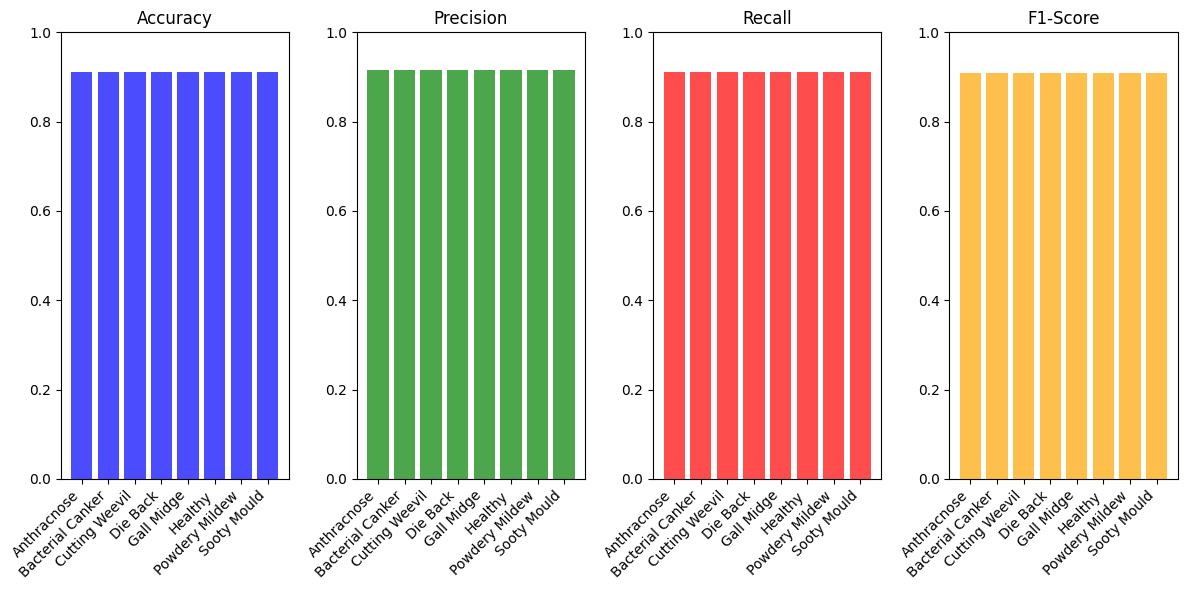

In [65]:
# metric values
accuracy_values = [accuracy6]
precision_values = [precision6]
recall_values = [recall6]
f1_values = [f1_6]

# bar plots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.bar(class_names, accuracy_values, color='b', alpha=0.7)
plt.ylim([0, 1])
plt.title('Accuracy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 2)
plt.bar(class_names, precision_values, color='g', alpha=0.7)
plt.ylim([0, 1])
plt.title('Precision')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 3)
plt.bar(class_names, recall_values, color='r', alpha=0.7)
plt.ylim([0, 1])
plt.title('Recall')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 4)
plt.bar(class_names, f1_values, color='orange', alpha=0.7)
plt.ylim([0, 1])
plt.title('F1-Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
# model7

In [66]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class PrintAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') * 100
        print(f'Accuracy: {accuracy:.2f}%')

def seventh_advanced_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def train_advanced_cnn_model(model, train_images, train_labels, test_images, test_labels, num_epochs, batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print_accuracy_callback = PrintAccuracyCallback()
    model.summary()
    advanced_cnn_hist = model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,
                                  validation_data=(test_images, test_labels),
                                  callbacks=[early_stopping, reduce_lr, print_accuracy_callback])
    return advanced_cnn_hist

# constants
image_height = 224
image_width = 224
num_channels = 3
num_classes = 8
num_epochs = 30
batch_size = 15

model7 = seventh_advanced_cnn_model(input_shape=(image_height, image_width, num_channels), num_classes=num_classes)

advanced_cnn_hist = train_advanced_cnn_model(model7, train_images, train_labels, test_images, test_labels, num_epochs, batch_size)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 52, 52, 128)      

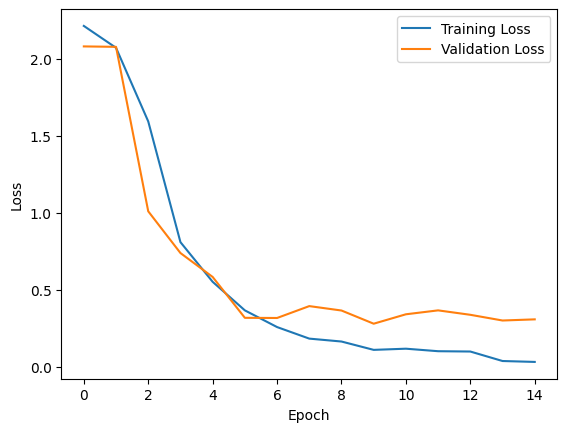

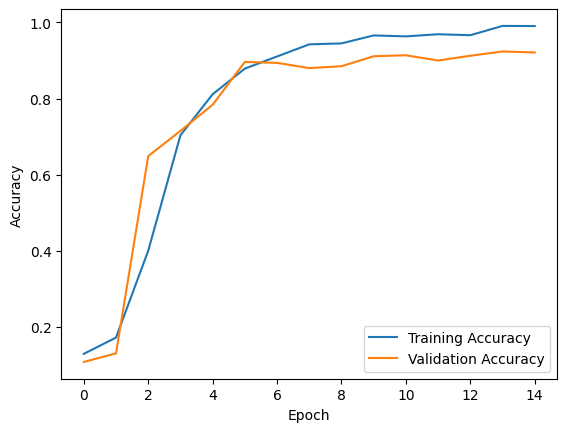

In [67]:
# training and validation loss
plt.plot(advanced_cnn_hist.history['loss'], label='Training Loss')
plt.plot(advanced_cnn_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# training and validation accuracy
plt.plot(advanced_cnn_hist.history['accuracy'], label='Training Accuracy')
plt.plot(advanced_cnn_hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

25/25 [==============================] - 2s 87ms/step


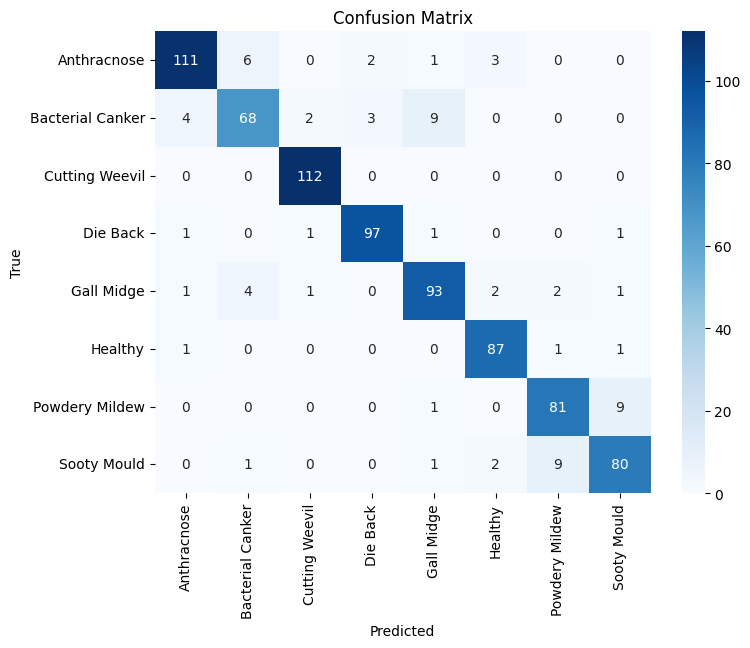

In [68]:
preds = model7.predict(test_images)
predicted_labels = np.argmax(preds, axis=1)

class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

conf_mat_adv = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_adv, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [69]:
test_labels_one_hot = to_categorical(test_labels, num_classes)

predicted_probabilities7 = model7.predict(test_images)

roc_curves7 = []
auc_scores7 = []

for class_index in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_one_hot[:, class_index], predicted_probabilities7[:, class_index])
    roc_curves7.append((fpr, tpr))
    auc_scores7.append(auc(fpr, tpr))

25/25 [==============================] - 2s 88ms/step


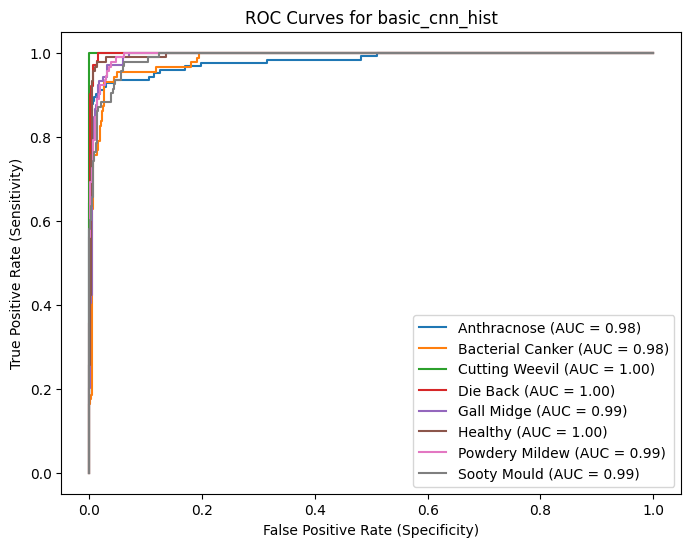

In [70]:
class_names = [
    "Anthracnose",
    "Bacterial Canker",
    "Cutting Weevil",
    "Die Back",
    "Gall Midge",
    "Healthy",
    "Powdery Mildew",
    "Sooty Mould"
]

plt.figure(figsize=(8, 6))

for class_index in range(num_classes):
    fpr, tpr = roc_curves7[class_index]
    auc_score7 = auc(fpr, tpr)

    label = f'{class_names[class_index]} (AUC = {auc_score7:.2f})'

    plt.plot(fpr, tpr, label=label)

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for basic_cnn_hist')
plt.legend(loc='lower right')

plt.show()

In [71]:
y_true7 = test_labels  # True labels
y_pred7 = predicted_probabilities7.argmax(axis=1)  # Predicted labels

accuracy7 = accuracy_score(y_true7, y_pred7)
print(f'Accuracy: {accuracy7:.2f}')

precision7 = precision_score(y_true7, y_pred7, average='macro')
recall7 = recall_score(y_true7, y_pred7, average='macro')
f1_7 = f1_score(y_true7, y_pred7, average='macro')

print(f'Precision: {precision7:.2f}')
print(f'Recall: {recall7:.2f}')
print(f'F1-Score: {f1_7:.2f}')

Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-Score: 0.91


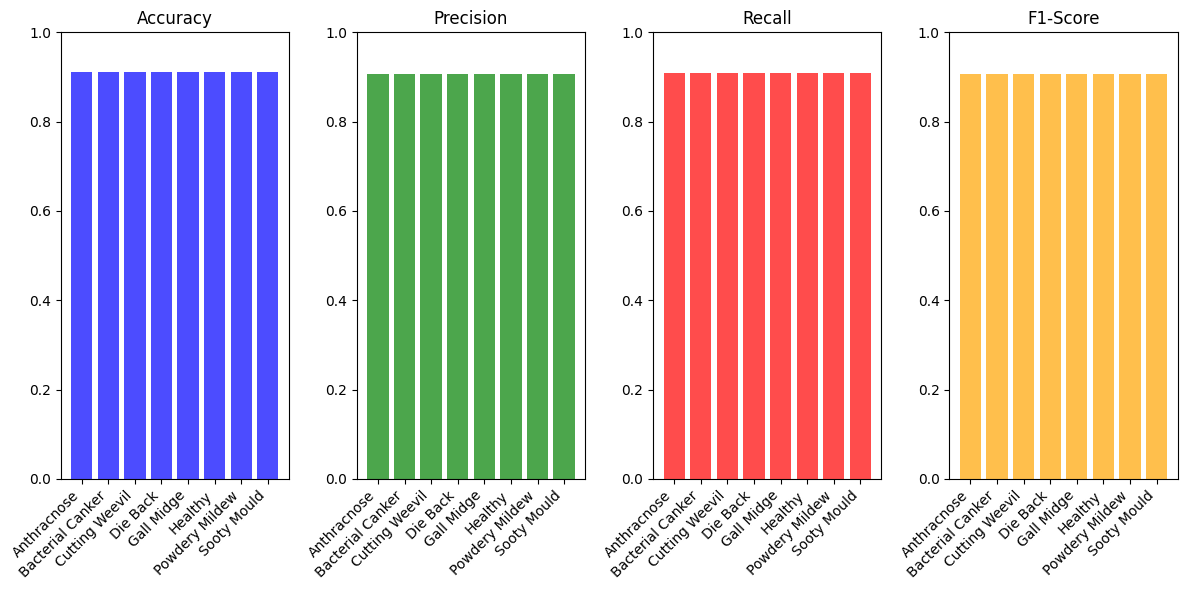

In [74]:
# metric values
accuracy_values = [accuracy7]
precision_values = [precision7]
recall_values = [recall7]
f1_values = [f1_7]

# bar plots for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.bar(class_names, accuracy_values, color='b', alpha=0.7)
plt.ylim([0, 1])
plt.title('Accuracy')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 2)
plt.bar(class_names, precision_values, color='g', alpha=0.7)
plt.ylim([0, 1])
plt.title('Precision')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 3)
plt.bar(class_names, recall_values, color='r', alpha=0.7)
plt.ylim([0, 1])
plt.title('Recall')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 4, 4)
plt.bar(class_names, f1_values, color='orange', alpha=0.7)
plt.ylim([0, 1])
plt.title('F1-Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()